In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import tensorflow as tf

from pathlib import Path

if 'automl/efficientnetv2' not in sys.path:
    sys.path.append('automl/efficientnetv2')
    
import matplotlib.pyplot as plt

In [2]:
MODEL = 'efficientnetv2-b0'  #@param
import effnetv2_model
# %load_ext tensorboard
# %tensorboard --logdir tb

In [3]:
# !mkdir -p chkpts images labels

In [4]:
MODEL = 'efficientnetv2-b0'
CHKPTS_DIR  = Path('chkpts')
LABELS_PATH = Path('labels/labels_map.txt')
IMAGES_PATH = Path('images/panda.jpg')

MODELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{MODEL}.tgz'
LABELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt'
IMAGES_URL = f'https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG'

In [5]:
# Download model
# !wget $MODELS_URL -P $CHKPTS_DIR
# !tar -xvf {CHKPTS_DIR}/{MODEL}.tgz -C {CHKPTS_DIR}

In [6]:
if tf.io.gfile.isdir( CHKPTS_DIR / MODEL ):
    chkpts_path = tf.train.latest_checkpoint(CHKPTS_DIR / MODEL)
chkpts_path

'chkpts/efficientnetv2-b0/model'

In [7]:
# Download label map file
# !wget $LABELS_URL -O $LABELS_PATH

In [8]:
# Download images
# !wget $IMAGES_URL -O $IMAGES_PATH

2022-03-17 22:01:15.355504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


top 1 ( 63.1%):  giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 
top 2 (  5.1%):  American black bear, black bear, Ursus americanus, Euarctos americanus 
top 3 (  1.8%):  hog, pig, grunter, squealer, Sus scrofa 
top 4 (  1.2%):  white wolf, Arctic wolf, Canis lupus tundrarum 
top 5 (  1.1%):  brown bear, bruin, Ursus arctos 


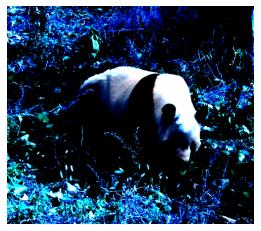

In [9]:
import preprocessing

# Build model
tf.keras.backend.clear_session()
model = effnetv2_model.EffNetV2Model(model_name=MODEL)
_ = model(tf.ones([1, 224, 224, 3]), training=False)
model.load_weights(chkpts_path)
cfg = model.cfg

# Pre-processing
img_opencv = cv2.imread(IMAGES_PATH.as_posix())

# These operations have been extracted out of the scripts
# preprocessing.py and preprecess_legacy.py. The exact operations
# do not match (as evidenced in the visualization) the ones used 
# by the scripts themselves.
# As this is simply a demo for a pre-trained model, it's good
# enough as a proof of concept. The natural consequence is that
# the predictions are lower than the ones in the next section.

mean_rgb = [0.485 * 255, 0.456 * 255, 0.406 * 255]
stddev_rgb = [0.229 * 255, 0.224 * 255, 0.225 * 255]
img_opencv = img_opencv - mean_rgb
img_opencv = img_opencv / stddev_rgb
img_opencv = np.expand_dims(img_opencv, axis=0)
logits = model(img_opencv, False)

# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[::-1][:5].numpy()
import ast
classes = ast.literal_eval(open(LABELS_PATH, "r").read())
for i, id in enumerate(idx):
    print(f'top {i+1} ({pred[0][id]*100:5.1f}%):  {classes[id]} ')

fig = plt.figure(facecolor='w', edgecolor='k', frameon=False)
ax = fig.add_subplot(111)
# plt.imshow(img_opencv[0])
plt.imshow(img_opencv[0])
_ = ax.set_aspect('equal')
ax.set_axis_off()
plt.show()

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


top 1 ( 86.9%):  giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 
top 2 (  0.4%):  lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens 
top 3 (  0.2%):  French bulldog 
top 4 (  0.1%):  ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus 
top 5 (  0.1%):  American black bear, black bear, Ursus americanus, Euarctos americanus 


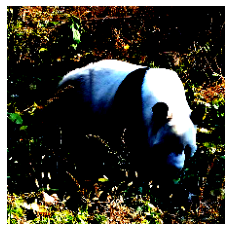

In [10]:
# Run inference for a given image
image = tf.io.read_file(str(IMAGES_PATH))
image = preprocessing.preprocess_image(
    image, cfg.eval.isize, is_training=False, augname=cfg.data.augname)
logits = model(tf.expand_dims(image, 0), False)

# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[::-1][:5].numpy()
import ast
classes = ast.literal_eval(open(LABELS_PATH, "r").read())
for i, id in enumerate(idx):
    print(f'top {i+1} ({pred[0][id]*100:5.1f}%):  {classes[id]} ')
# from IPython import display
# display.display(display.Image(IMAGES_PATH))
fig = plt.figure(facecolor='w', edgecolor='k', frameon=False)
ax = fig.add_subplot(111)
# plt.imshow(img_opencv[0])
plt.imshow(image)
_ = ax.set_aspect('equal')
ax.set_axis_off()
plt.show()